In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt
import re

SEED = 2024
np.random.seed(SEED)

In [2]:
adata_rna = sc.read_h5ad("adata/redeem_young.h5ad")
print(adata_rna)

AnnData object with n_obs × n_vars = 9144 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'MitoCoverage', 'ClonalGroup', 'ClonalGroup.Prob', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'CellType', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CellType_colors', 'STD.CellType_colors', 'neighbors', 'umap', 'velocity_gra

In [3]:
adata_atac = sc.read_10x_mtx('/home/liyr/Redeem/young2_HSPC_Multi/outs/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

In [4]:
adata_atac = mv.aggregate_peaks_10x(adata_atac, 
                                    '/home/liyr/Redeem/young2_HSPC_Multi/outs/atac_peak_annotation.tsv', 
                                    '/home/liyr/Redeem/young2_HSPC_Multi/outs/analysis/feature_linkage/feature_linkage.bedpe')

  0%|          | 0/21846 [00:00<?, ?it/s]

In [5]:
sc.pp.filter_cells(adata_atac, min_counts=2000)
sc.pp.filter_cells(adata_atac, max_counts=60000)

In [6]:
# We normalize aggregated peaks with TF-IDF.
mv.tfidf_norm(adata_atac)

In [7]:
adata_atac.obs_names  = [re.sub(r'-1', '', s) for s in adata_atac.obs_names.tolist()]
adata_rna.obs_names  = [re.sub(r'-2', '', s) for s in adata_rna.obs_names.tolist()]
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)

(8253, 1359)

In [8]:
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

adata_rna
adata_atac

View of AnnData object with n_obs × n_vars = 8253 × 1359
    obs: 'n_counts'

In [9]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
scv.pp.moments(adata_rna)

/tmp/ipykernel_41601/2331308133.py:2: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
# Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
adata_rna.obs_names.to_frame().to_csv('sup/multivelo/multivelo_filtered_cells.txt', header=False, index=False)

In [11]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("sup/multivelo/nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("sup/multivelo/nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("sup/multivelo/nn_cells.txt", header=None)[0])

In [12]:
# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)

True

In [13]:
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

In [14]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                         adata_atac
                                         #max_iter=5, 
                                         #init_mode="invert",
                                         #parallel=True, 
                                         #save_plot=False,
                                         #rna_only=False,
                                         #fit=True,
                                         #n_anchors=500
                                        )

/home/liyr/miniconda3/envs/MultiVelo/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1359 [00:00<?, ?it/s]

In [15]:
# Save the result for use later on
adata_result.write("adata/multivelo_result.h5ad")

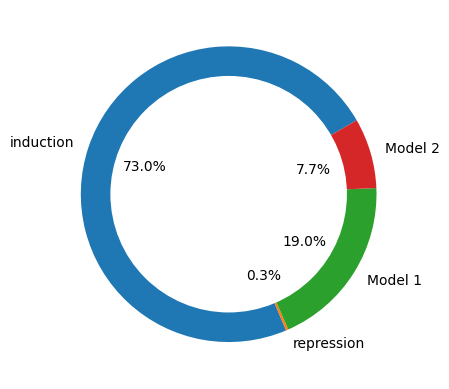

In [16]:
mv.pie_summary(adata_result)

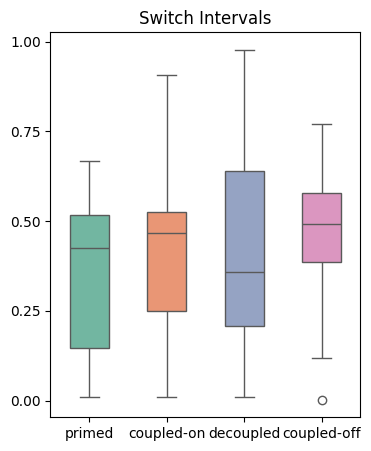

In [17]:
mv.switch_time_summary(adata_result)

In [18]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/52 cores)


/home/liyr/miniconda3/envs/MultiVelo/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/8253 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 6 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


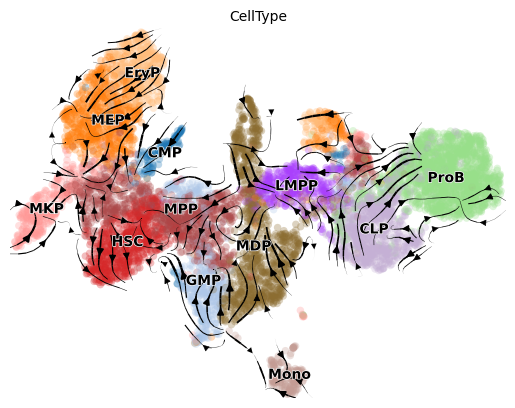

In [19]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='CellType')